# Fast GP implementations

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [2]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = 12, 4

## Benchmarking GP codes
Implemented the right way, GPs can be super fast! Let's compare the time it takes to evaluate our GP likelihood and the time it takes to evaluate the likelihood computed with the snazzy ``george`` and ``celerite`` packages. We'll learn how to use both along the way. Let's create a large, fake dataset for these tests:

In [3]:
import numpy as np

np.random.seed(0)
t = np.linspace(0, 10, 10000)
y = np.random.randn(10000)
sigma = np.ones(10000)

### Our GP

In [4]:
def ExpSquaredCovariance(t, A=1.0, l=1.0, tprime=None):
    """
    Return the ``N x M`` exponential squared
    covariance matrix.
    
    """
    if tprime is None:
        tprime = t
    TPrime, T = np.meshgrid(tprime, t)
    return A ** 2 * np.exp(-0.5 * (T - TPrime) ** 2 / l ** 2)


def ln_gp_likelihood(t, y, sigma=0, A=1.0, l=1.0):
    """
    Return the log of the GP likelihood for a datatset y(t)
    with uncertainties sigma, modeled with a Squared Exponential
    Kernel with amplitude A and lengthscale l.
    
    """
    # The covariance and its determinant
    npts = len(t)
    K = ExpSquaredCovariance(t, A=A, l=l) + sigma ** 2 * np.eye(npts)
    
    # The log marginal likelihood
    log_like = -0.5 * np.dot(y.T, np.linalg.solve(K, y))
    log_like -= 0.5 * np.linalg.slogdet(K)[1]
    log_like -= 0.5 * npts * np.log(2 * np.pi)
    
    return log_like

Time to evaluate the GP likelihood:

In [5]:
%%time
ln_gp_likelihood(t, y, sigma)

CPU times: user 40.3 s, sys: 2.79 s, total: 43.1 s
Wall time: 8.46 s


-14095.321368970013

### george

Let's time how long it takes to do the same operation using the ``george`` package (``pip install george``).

The kernel we'll use is

```python
kernel = amp ** 2 * george.kernels.ExpSquaredKernel(tau ** 2)
```

where ``amp = 1`` and ``tau = 1`` in this case.

To instantiate a GP using ``george``, simply run

```python
gp = george.GP(kernel)
```

The ``george`` package pre-computes a lot of matrices that are re-used in different operations, so before anything else, we'll ask it to compute the GP model for our timeseries:

```python
gp.compute(t, sigma)
```

Note that we've only given it the time array and the uncertainties, so as long as those remain the same, you don't have to re-compute anything. This will save you a lot of time in the long run!

Finally, the log likelihood is given by ``gp.log_likelihood(y)``.

How do the speeds compare? Did you get the same value of the likelihood?

In [6]:
import george

In [7]:
%%time
kernel = george.kernels.ExpSquaredKernel(1.0)
gp = george.GP(kernel)
gp.compute(t, sigma)

CPU times: user 11.5 s, sys: 541 ms, total: 12 s
Wall time: 3.53 s


In [8]:
%%time
print(gp.log_likelihood(y))

-14095.32136897017
CPU times: user 915 ms, sys: 24.2 ms, total: 940 ms
Wall time: 119 ms


``george`` also offers a fancy GP solver called the HODLR solver, which makes some approximations that dramatically speed up the matrix algebra. Let's instantiate the GP object again by passing the keyword ``solver=george.HODLRSolver`` and re-compute the log likelihood. How long did that take? Did we get the same value for the log likelihood?

In [9]:
%%time
gp = george.GP(kernel, solver=george.HODLRSolver)
gp.compute(t, sigma)

CPU times: user 47.9 ms, sys: 69.5 ms, total: 117 ms
Wall time: 116 ms


In [10]:
%%time
gp.log_likelihood(y)

CPU times: user 4.06 ms, sys: 842 µs, total: 4.9 ms
Wall time: 4.35 ms


-14116.16895539657

**We don't get the same value for the log likelihood but it seems pretty close. Especially for the orders of magnitude computationall speed up!**

### celerite

The ``george`` package is super useful for GP modeling, and I recommend you read over the [docs and examples](https://george.readthedocs.io/en/latest/). It implements several different [kernels](https://george.readthedocs.io/en/latest/user/kernels/) that come in handy in different situations, and it has support for multi-dimensional GPs. But if all you care about are GPs in one dimension (in this case, we're only doing GPs in the time domain, so we're good), then ``celerite`` is what it's all about:

```bash
pip install celerite
```

Check out the [docs](https://celerite.readthedocs.io/en/stable/) here, as well as several tutorials. There is also a [paper](https://arxiv.org/abs/1703.09710) that discusses the math behind ``celerite``. The basic idea is that for certain families of kernels, there exist **extremely efficient** methods of factorizing the covariance matrices. Whereas GP fitting typically scales with the number of datapoints $N$ as $N^3$, ``celerite`` is able to do everything in order $N$ (!!!) This is a **huge** advantage, especially for datasets with tens or hundreds of thousands of data points. Using ``george`` or any homebuilt GP model for datasets larger than about ``10,000`` points is simply intractable, but with ``celerite`` you can do it in a breeze.

Next we repeat the timing tests, but this time using ``celerite``. Note that the Exponential Squared Kernel is not available in ``celerite``, because it doesn't have the special form needed to make its factorization fast. Instead, we'll use the ``Matern 3/2`` kernel, which is qualitatively similar and can be approximated quite well in terms of the ``celerite`` basis functions:

```python
kernel = celerite.terms.Matern32Term(np.log(1), np.log(1))
```

Note that ``celerite`` accepts the **log** of the amplitude and the **log** of the timescale. Other than this, we can compute the likelihood using the same syntax as ``george``.

How much faster did it run? Is the value of the likelihood different from what you found above? Why?

In [5]:
import celerite
from celerite import terms

In [6]:
%%time
kernel = terms.Matern32Term(np.log(1), np.log(1))
gp = celerite.GP(kernel)
gp.compute(t, sigma)

CPU times: user 1.69 ms, sys: 996 µs, total: 2.68 ms
Wall time: 1.91 ms


In [7]:
%%time
gp.log_likelihood(y)

CPU times: user 593 µs, sys: 244 µs, total: 837 µs
Wall time: 667 µs


-14117.50219117748

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise (the one and only)</h1>
</div>

Let's use what we've learned about GPs in a real application: fitting an exoplanet transit model in the presence of correlated noise.

Here is a (fictitious) light curve for a star with a transiting planet: 

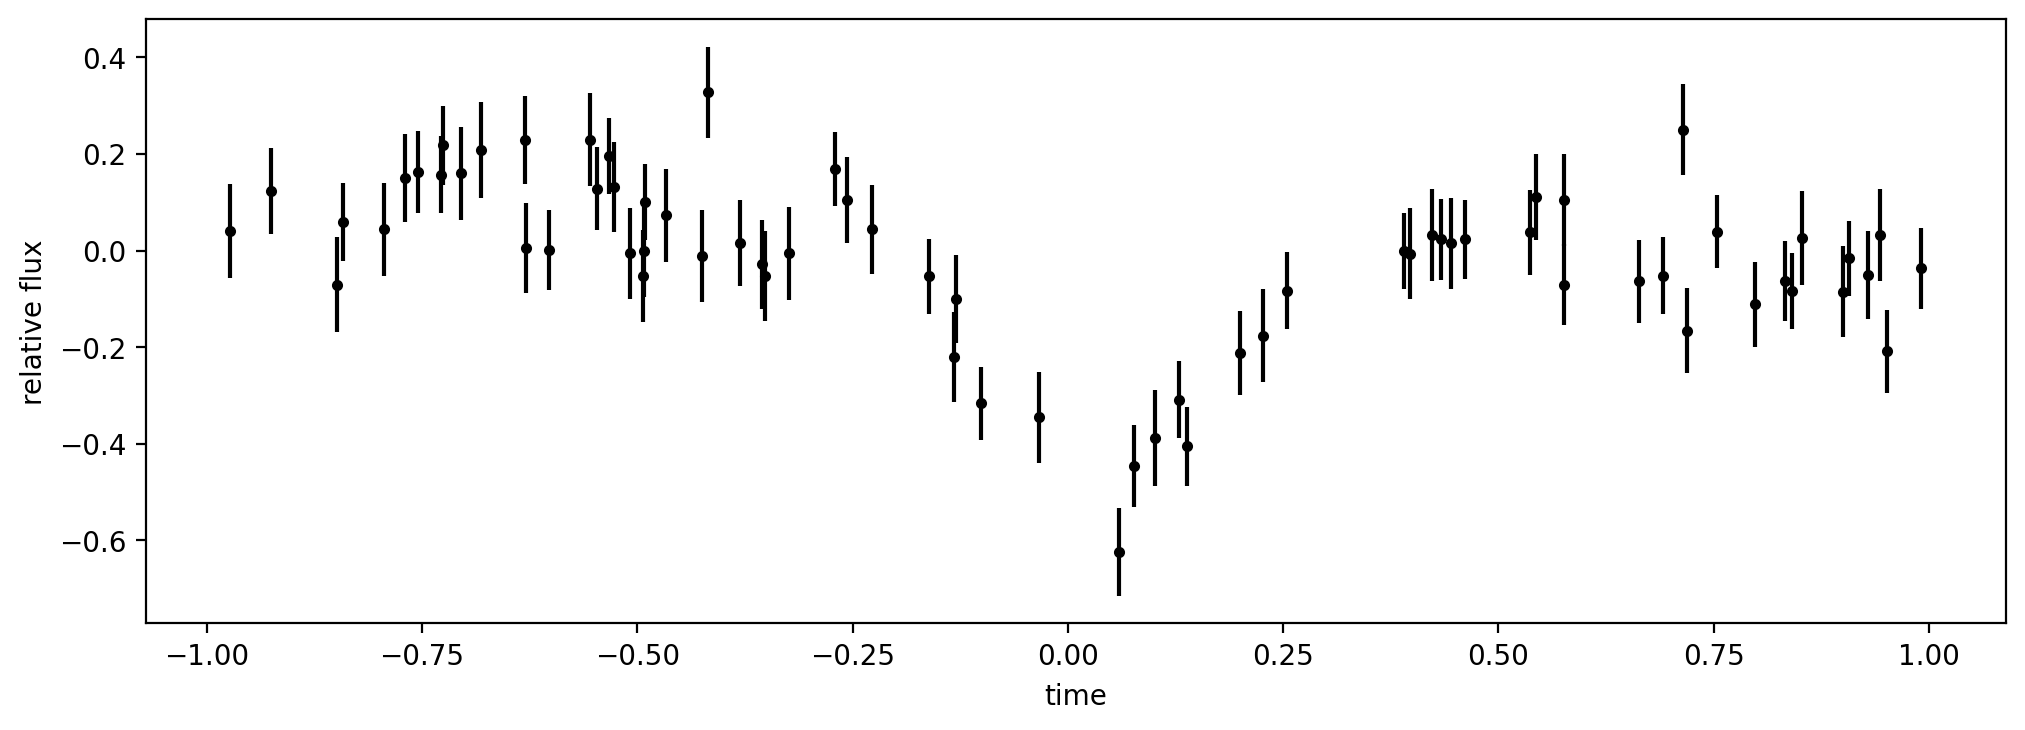

In [113]:
import matplotlib.pyplot as plt

t, y, yerr = np.loadtxt("data/sample_transit.txt", unpack=True)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("time")
plt.ylabel("relative flux");

There is a transit visible to the eye at $t = 0$, which (say) is when you'd expect the planet to transit if its orbit were perfectly periodic. However, a recent paper claims that the planet shows transit timing variations, which are indicative of a second, perturbing planet in the system, and that a transit at $t = 0$ can be ruled out at 3 $\sigma$. **Your task is to verify this claim.**

Assume you have no prior information on the planet other than the transit occurs in the observation window, the depth of the transit is somewhere in the range $(0, 1)$, and the transit duration is somewhere between $0.1$ and $1$ day. You don't know the exact process generating the noise, but you are certain that there's correlated noise in the dataset, so you'll have to pick a reasonable kernel and estimate its hyperparameters.


Fit the transit with a simple inverted Gaussian with three free parameters:

```python
def transit_shape(depth, t0, dur):
    return -depth * np.exp(-0.5 * (t - t0) ** 2 / (0.2 * dur) ** 2)
```

*HINT: I borrowed heavily from [this tutorial](https://celerite.readthedocs.io/en/stable/tutorials/modeling/) in the celerite documentation, so you might want to take a look at it...*

Initial log-likelihood: 48.5497171287075
Final log-likelihood: 67.23717247406594


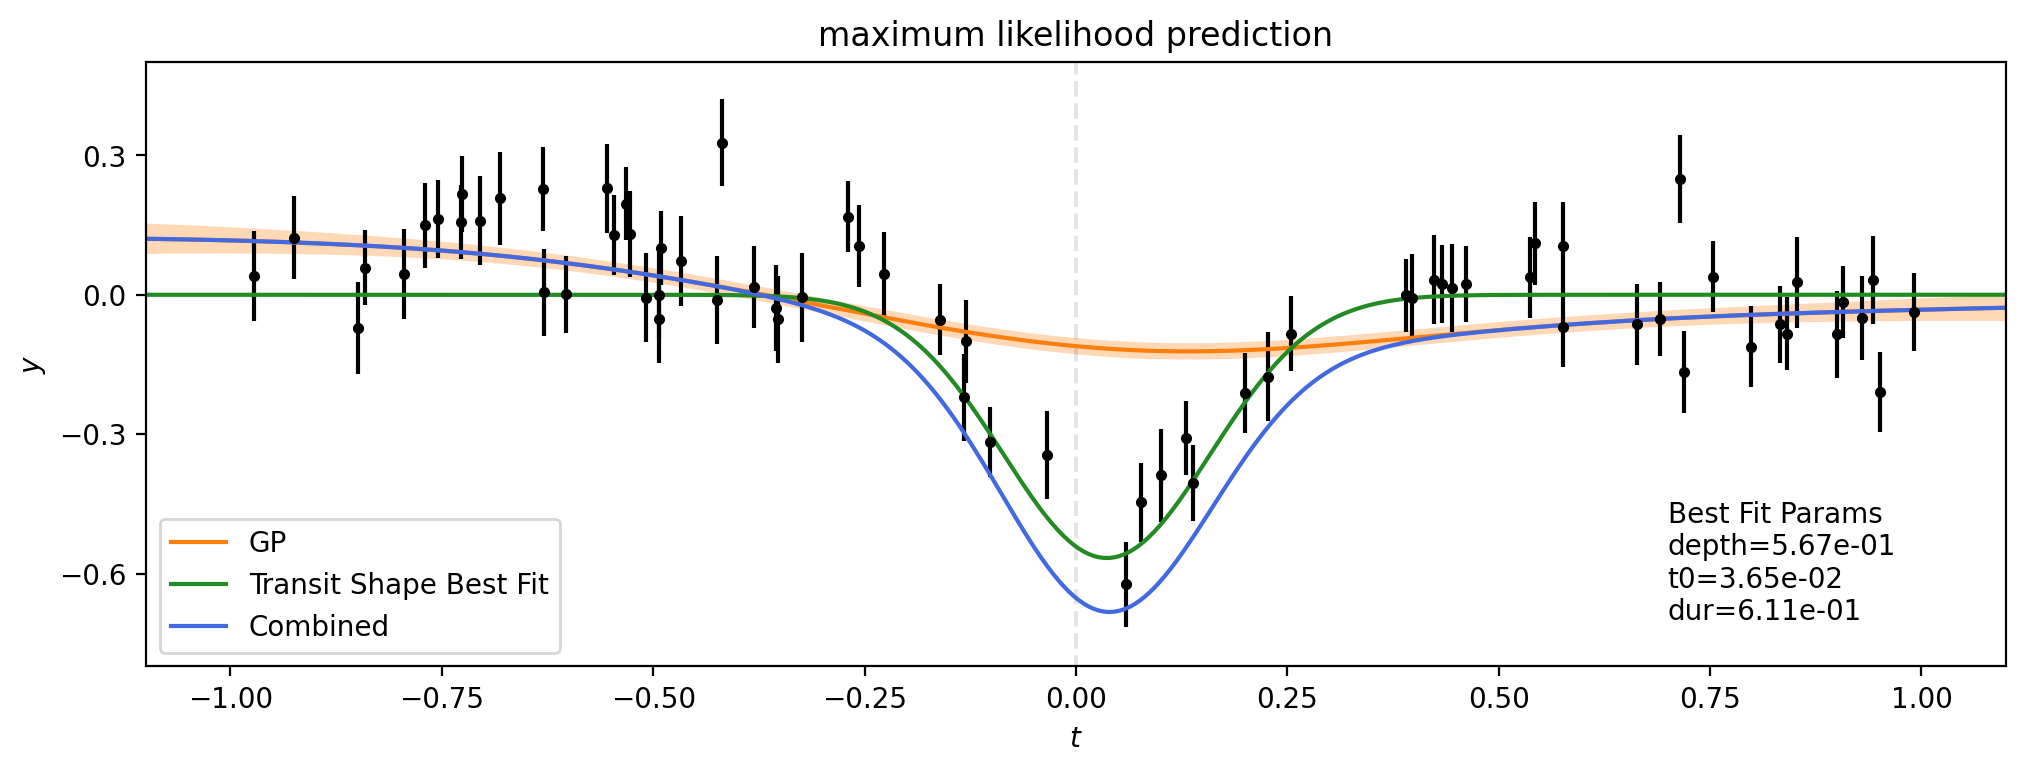

In [123]:
from scipy.optimize import minimize

import celerite
from celerite import terms

def transit_shape(depth, t0, dur):
    return -depth * np.exp(-0.5 * (t - t0) ** 2 / (0.2 * dur) ** 2)


kernel = terms.Matern32Term( np.log(1), np.log(1) )
gp = celerite.GP(kernel)
gp.compute(t, yerr)
print("Initial log-likelihood: {0}".format(gp.log_likelihood(y)))

# Define a cost function
def neg_log_like(params, y, gp):
    gp_p1, gp_p2, depth, t0, dur = params
    
    gp.set_parameter_vector([gp_p1, gp_p2])
    
    return -gp.log_likelihood( y - transit_shape(depth, t0, dur) )


# Fit for the maximum likelihood parameters
initial_params = [0,0,1,0,1]#gp.get_parameter_vector()
bounds = [(None, None)]*len(initial_params)#gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params,
                method="L-BFGS-B", bounds=bounds, 
                args=(y, gp)
               )

gp.set_parameter_vector( soln.x[0:2] )
print("Final log-likelihood: {0}".format(-soln.fun))



# Make the maximum likelihood prediction
x = np.linspace(-1.5, 1.5, 500)
mu, var = gp.predict(y, x, return_var=True)
std = np.sqrt(var)

# Plot the data
color = "#ff7f0e"
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, mu, color=color, label='GP')
plt.fill_between(x, mu+std, mu-std, color=color, alpha=0.3, edgecolor="none")
plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.xlim(-1.1,1.1)

plot_transit_shape = lambda depth, t0, dur, x : -depth * np.exp(-0.5 * (x - t0) ** 2 / (0.2 * dur) ** 2)
plt.plot(x, plot_transit_shape(*soln.x[2:], x), color='forestgreen', 
         label='Transit Shape Best Fit' )

plt.text(0.7, -0.7, s='Best Fit Params\ndepth={0:.2e}\nt0={1:.2e}\ndur={2:.2e}'.format(*soln.x[2:]))

plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.vlines(0,-1,1, ls='--', color='k', alpha=0.1)
plt.ylim(-0.8, 0.5)


plt.plot(x, mu+plot_transit_shape(*soln.x[2:], x), color='royalblue', label='Combined')


plt.legend(loc='lower left')
plt.title("maximum likelihood prediction");
plt.show()

In [124]:
def lnprob(p):
    """
    
    """
    gp_p1, gp_p2, depth, t0, dur = p
    if depth < 0 or t0 < 0 or dur < 0: 
        return -np.inf
    if depth > 10 or t0 > 10 or dur > 10:
        return -np.inf
    gp.set_parameter_vector([gp_p1, gp_p2])
    model = transit_shape(depth, t0, dur)
    return -gp.log_likelihood( y - model )


In [125]:
import emcee
print("Using emcee version {0}".format(emcee.__version__))

gp_init_1, gp_init_2 = gp.get_parameter_vector()
initial = [gp_init_1, gp_init_2, 0, 0.5, 0]
ndim = len(initial)
nwalkers = 32
p0 = initial + 1e-3 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, 1600, progress=True)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 2500, progress=True);

Using emcee version 3.1.1
Running burn-in...


  0%|                                                                                                                                  | 0/1600 [00:00<?, ?it/s]/opt/anaconda3/envs/DSFP/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  4%|████▊                                                                                                                   | 64/1600 [00:00<00:04, 312.37it/s]Traceback (most recent call last):
  File "/opt/anaconda3/envs/DSFP/lib/python3.8/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/j2/tlw62j517hb6ch7m280c_66h0000gn/T/ipykernel_5592/2452244550.py", line 12, in lnprob
    return -gp.log_likelihood( y - model )
  File "/opt/anaconda3/envs/DSFP/lib/python3.8/site-packages/celerite/celerite.py", line 204, in log_likelihood
    self._recompute()
  File "/opt/anaconda3/envs/D

emcee: Exception while calling your likelihood function:
  params: [27.78351923 83.39608697  1.73411754  5.72081983  4.41489472]
  args: []
  kwargs: {}
  exception:


LinAlgError: failed to factorize or solve matrix

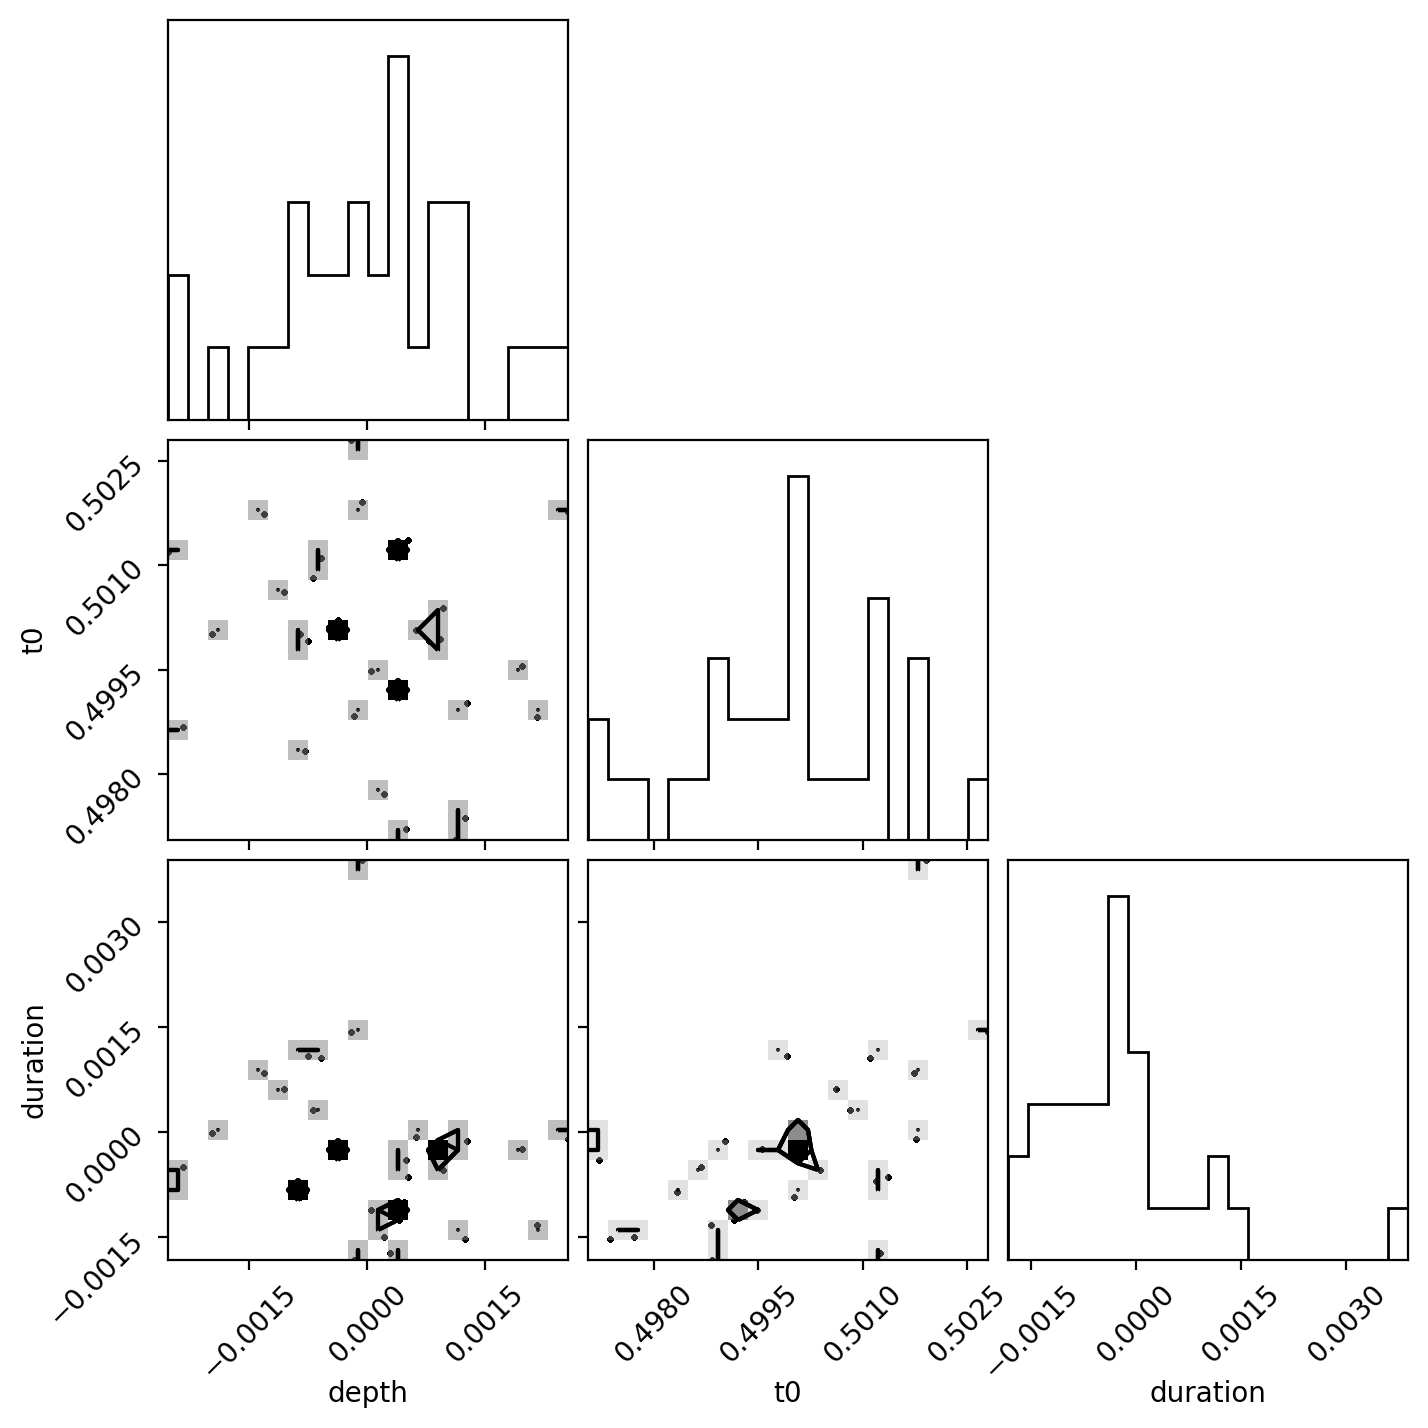

In [121]:
import corner
labels = ["depth", "t0", "duration"]
# truths = [m_true, b_true]
corner.corner(sampler.flatchain[:,2:], truths=None, labels=labels);